In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

# 데이터 불러오기

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Zipbob_timeseries/농수산DB기본전처리.csv', encoding='cp949')

In [5]:
data

,itemnm,kindnm,regdate,price,itemkind
0,팥,붉은 팥(국산)(1kg),1996-01-03,3375,팥-붉은 팥(국산)(1kg)
1,팥,붉은 팥(국산)(1kg),1996-01-04,3375,팥-붉은 팥(국산)(1kg)
2,팥,붉은 팥(국산)(1kg),1996-01-05,3375,팥-붉은 팥(국산)(1kg)
3,팥,붉은 팥(국산)(1kg),1996-01-08,3375,팥-붉은 팥(국산)(1kg)
4,팥,붉은 팥(국산)(1kg),1996-01-09,3375,팥-붉은 팥(국산)(1kg)
...,...,...,...,...,...
314265,피마늘,한지(1kg),2020-12-24,8000,피마늘-한지(1kg)
314266,피마늘,한지(1kg),2020-12-28,8000,피마늘-한지(1kg)
314267,피마늘,한지(1kg),2020-12-29,8000,피마늘-한지(1kg)
314268,피마늘,한지(1kg),2020-12-30,8000,피마늘-한지(1kg)


# 필요 라이브러리 설치

In [ ]:
!pip install tzlocal
import tzlocal
!pip install rpy2
import rpy2
!pip install pmdarima==1.5.3
import pmdarima
import statsmodels
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from rpy2.robjects.packages import importr

utils = importr('utils')
utils.install_packages('forecast')

In [8]:
data1 = data.copy()

# 특정 컬럼값 선택하여 train-test 분할

In [9]:
data1 = data1[data1['itemkind']=='미나리-미나리(1kg)']

In [10]:
data1 # 미나리로 일단 코드 테스트 후 전체 코드 진행

,itemnm,kindnm,regdate,price,itemkind
118375,미나리,미나리(1kg),1996-01-03,1700,미나리-미나리(1kg)
118376,미나리,미나리(1kg),1996-01-04,1500,미나리-미나리(1kg)
118377,미나리,미나리(1kg),1996-01-05,1400,미나리-미나리(1kg)
118378,미나리,미나리(1kg),1996-01-08,1400,미나리-미나리(1kg)
118379,미나리,미나리(1kg),1996-01-09,1300,미나리-미나리(1kg)
...,...,...,...,...,...
203013,미나리,미나리(1kg),2021-09-10,9067,미나리-미나리(1kg)
203014,미나리,미나리(1kg),2021-09-13,9933,미나리-미나리(1kg)
203015,미나리,미나리(1kg),2021-09-14,10400,미나리-미나리(1kg)
203016,미나리,미나리(1kg),2021-09-15,12933,미나리-미나리(1kg)


In [11]:
traindf = data1.copy()
traindf['regdate'] = pd.to_datetime(traindf['regdate'],format="%Y-%m-%d")

In [12]:
# 8월 한달 test(동일한 기간으로 테스트 진행)
test8 = traindf[(traindf['regdate'] >= '2021-08-01') & (traindf['regdate'] <= '2021-08-31')]

In [16]:
# test 생성 후 train 시계열 기간 설정
train_split = traindf[traindf['regdate'] < '2021-08-01']
train_split

,itemnm,kindnm,regdate,price,itemkind
118375,미나리,미나리(1kg),1996-01-03,1700,미나리-미나리(1kg)
118376,미나리,미나리(1kg),1996-01-04,1500,미나리-미나리(1kg)
118377,미나리,미나리(1kg),1996-01-05,1400,미나리-미나리(1kg)
118378,미나리,미나리(1kg),1996-01-08,1400,미나리-미나리(1kg)
118379,미나리,미나리(1kg),1996-01-09,1300,미나리-미나리(1kg)
...,...,...,...,...,...
202980,미나리,미나리(1kg),2021-07-26,4000,미나리-미나리(1kg)
202981,미나리,미나리(1kg),2021-07-27,4000,미나리-미나리(1kg)
202982,미나리,미나리(1kg),2021-07-28,4000,미나리-미나리(1kg)
202983,미나리,미나리(1kg),2021-07-29,4000,미나리-미나리(1kg)


In [14]:
# 2021년 5,6월까지 데이터 없을 때 실행 후 진행
train_split = traindf.copy()

In [17]:
train_split = train_split.drop(['itemnm', 'kindnm'], axis=1)

In [18]:
train_split

,regdate,price,itemkind
118375,1996-01-03,1700,미나리-미나리(1kg)
118376,1996-01-04,1500,미나리-미나리(1kg)
118377,1996-01-05,1400,미나리-미나리(1kg)
118378,1996-01-08,1400,미나리-미나리(1kg)
118379,1996-01-09,1300,미나리-미나리(1kg)
...,...,...,...
202980,2021-07-26,4000,미나리-미나리(1kg)
202981,2021-07-27,4000,미나리-미나리(1kg)
202982,2021-07-28,4000,미나리-미나리(1kg)
202983,2021-07-29,4000,미나리-미나리(1kg)


In [19]:
test8 = test8.drop(['itemnm', 'kindnm'], axis=1)

In [ ]:
test8

# 시계열 ARIMA, ETS, fbprophet 3개로 비교하기

# 1. ARIMA 코드 실행

In [21]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

pandas2ri.activate()

auto_arima = """
    function(ts){
        library(stats)
        library(forecast)
        d_params = ndiffs(ts)
        model = auto.arima(ts, max.p=2, d=d_params)
        forecasted_data = forecast(model, h=31)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('predprice')
        out_df
    }
"""

auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')
c = robjects.r('c')

train_split_arima = ts(train_split['price'], frequency=1)

forecast = auto_arima(train_split_arima)

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [ ]:
# forecast출력
forecast['predprice']

In [23]:
arima_pred_8 = forecast['predprice'][:31]

In [24]:
arima_pred_8

1     3536.561166
2     3575.118603
3     3586.391438
4     3598.916489
5     3606.114162
6     3611.537399
7     3615.146988
8     3617.684097
9     3619.424324
10    3620.631000
11    3621.463666
12    3622.039488
13    3622.437309
14    3622.712272
15    3622.902281
16    3623.033597
17    3623.124345
18    3623.187060
19    3623.230401
20    3623.260353
21    3623.281052
22    3623.295357
23    3623.305243
24    3623.312075
25    3623.316796
26    3623.320059
27    3623.322314
28    3623.323872
29    3623.324949
30    3623.325693
31    3623.326208
Name: predprice, dtype: float64

In [25]:
ts_aug = pd.date_range('2021-08-01', '2021-08-31')
pred8dfarima = {'regdate':ts_aug, 'price_pred_8':arima_pred_8}
pred8dfarima = pd.DataFrame(pred8dfarima)

In [ ]:
pred8dfarima

In [27]:
pred8dfarima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 1 to 31
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   regdate       31 non-null     datetime64[ns]
 1   price_pred_8  31 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0+ KB


In [28]:
merge_l_arimafinal = pd.merge(test8, pred8dfarima, how='left',left_on='regdate', right_on='regdate')
merge_l_arimafinal

,regdate,price,itemkind,price_pred_8
0,2021-08-02,4440,미나리-미나리(1kg),3575.118603
1,2021-08-03,5667,미나리-미나리(1kg),3586.391438
2,2021-08-04,6667,미나리-미나리(1kg),3598.916489
3,2021-08-05,6440,미나리-미나리(1kg),3606.114162
4,2021-08-06,6867,미나리-미나리(1kg),3611.537399
5,2021-08-09,6667,미나리-미나리(1kg),3619.424324
6,2021-08-10,6867,미나리-미나리(1kg),3620.631000
7,2021-08-11,5553,미나리-미나리(1kg),3621.463666
8,2021-08-12,6440,미나리-미나리(1kg),3622.039488
9,2021-08-13,5553,미나리-미나리(1kg),3622.437309


실제값과 예측값의 차이를 비교하는 mae 함수 직접 만들어서 활용

In [29]:
def mae8(df) :
  n = len(df['itemkind'])
  df['dif'] = np.abs(df['price'] - df['price_pred_8'])
  result = sum(df['dif']) / n
  return result

In [30]:
mae8(merge_l_arimafinal)

3478.13788457764

# 2. ETS 코드 실행

In [31]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=31) # 이후 1개월(31일)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('predprice') # predprice 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수


train_split_ets = ts(train_split['price'], frequency=7)

forecast_ets = ets(train_split_ets)

In [32]:
ets_pred_8 = forecast_ets['predprice'][:31]
pred8df_ets = {'regdate':ts_aug, 'price_pred_8':ets_pred_8}
pred8df_ets = pd.DataFrame(pred8df_ets)
merge_l_etsfinal = pd.merge(test8, pred8df_ets, how='left',left_on='regdate', right_on='regdate')

In [33]:
merge_l_etsfinal

,regdate,price,itemkind,price_pred_8
0,2021-08-02,4440,미나리-미나리(1kg),3580.764980
1,2021-08-03,5667,미나리-미나리(1kg),3593.454306
2,2021-08-04,6667,미나리-미나리(1kg),3606.143632
3,2021-08-05,6440,미나리-미나리(1kg),3618.832958
4,2021-08-06,6867,미나리-미나리(1kg),3631.522284
5,2021-08-09,6667,미나리-미나리(1kg),3669.590263
6,2021-08-10,6867,미나리-미나리(1kg),3682.279589
7,2021-08-11,5553,미나리-미나리(1kg),3694.968915
8,2021-08-12,6440,미나리-미나리(1kg),3707.658241
9,2021-08-13,5553,미나리-미나리(1kg),3720.347568


In [34]:
mae8(merge_l_etsfinal) # arima 3478보다 감소함

3336.522040921872

# 3. fbprophet 실행

In [35]:
!python --version

Python 3.7.12


In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

In [37]:
import fbprophet
print(fbprophet.__version__)

0.7.1


In [38]:
from fbprophet import Prophet

In [39]:
ts_aug

DatetimeIndex(['2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04',
               '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08',
               '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-08-14', '2021-08-15', '2021-08-16',
               '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20',
               '2021-08-21', '2021-08-22', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28',
               '2021-08-29', '2021-08-30', '2021-08-31'],
              dtype='datetime64[ns]', freq='D')

In [40]:
testaugdf = {'ds':ts_aug}
testaugdf = pd.DataFrame(testaugdf)

In [ ]:
testaugdf

In [42]:
train_copy = train_split.copy()
train_copy = train_copy.rename(columns = {'regdate' : 'ds', 'price':'y'})

In [44]:
train_copy

,ds,y,itemkind
118375,1996-01-03,1700,미나리-미나리(1kg)
118376,1996-01-04,1500,미나리-미나리(1kg)
118377,1996-01-05,1400,미나리-미나리(1kg)
118378,1996-01-08,1400,미나리-미나리(1kg)
118379,1996-01-09,1300,미나리-미나리(1kg)
...,...,...,...
202980,2021-07-26,4000,미나리-미나리(1kg)
202981,2021-07-27,4000,미나리-미나리(1kg)
202982,2021-07-28,4000,미나리-미나리(1kg)
202983,2021-07-29,4000,미나리-미나리(1kg)


## fbprophet 비교시 주의할 점
- 시계열 예측의 날짜 변수는 컬럼명 'ds', 예측변수는 'y'로 지정해야 작동함
- 한번 train set으로 모델을 fit하면 model변수는 사용할 수 없으므로 파라미터를 조정할 때마다 model 새롭게 생성해야 함.

In [45]:
model = Prophet()
model.daily_seasonality=True
model.weekly_seasonality=True
model.yearly_seasonality=True

In [46]:
model.fit(train_copy)

forecast = model.predict(testaugdf)
y_pred = forecast['yhat'].values

## 기본적으로 fbprophet이 시계열 추세를 잘 반영한다. 그래프로 확인

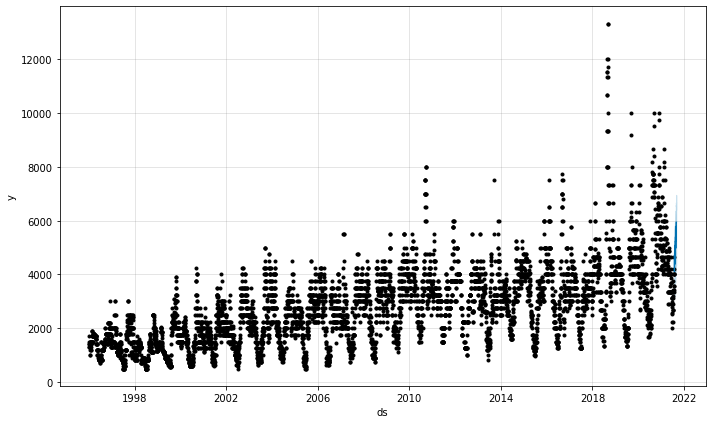

In [48]:
fig = model.plot(forecast)

## fbprophet으로 시계열 데이터의 추세(trend, yearly등)를 파악한 후 파라미터를 조정한다

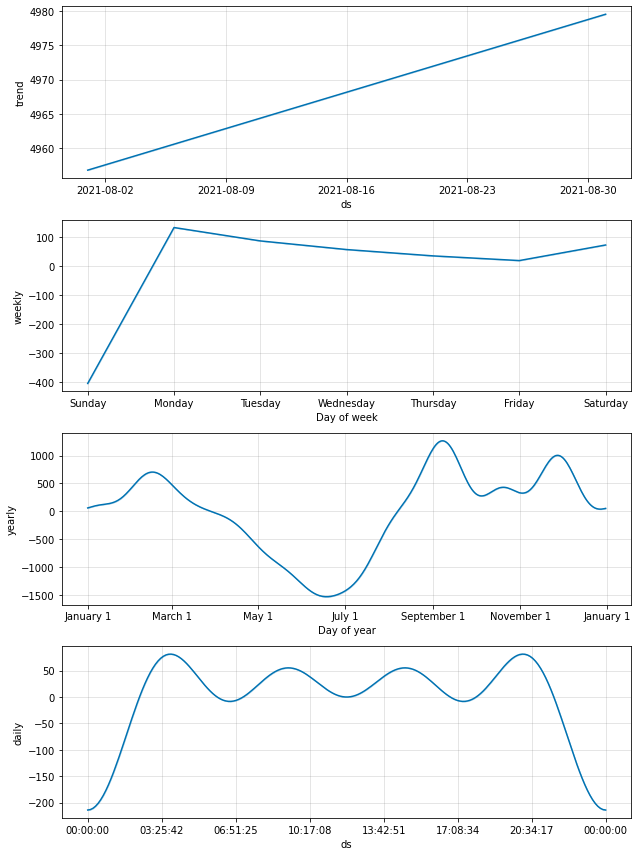

In [49]:
figs1 = model.plot_components(forecast)

In [50]:
y_pred

array([4117.59449378, 4697.73056631, 4691.58743813, 4700.51211408,
       4716.21878123, 4736.62751236, 4826.28348647, 4383.38765718,
       4957.17264137, 4946.24932932, 4952.1765169 , 4966.82748517,
       4988.22178035, 5080.93894495, 4643.14533494, 5223.96795775,
       5221.84094957, 5238.07705861, 5264.23807195, 5297.97239613,
       5403.43644385, 4978.33080892, 5571.28496085, 5580.21582723,
       5605.91233959, 5639.41955591, 5677.89022009, 5785.02004437,
       5358.09732421, 5945.4002476 , 5944.56691119])

In [51]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [ ]:
pred8df_fb

In [53]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

ARIMA, ETS보다 절반 이하로 오차값 줄어듬을 확인

In [54]:
mae8(merge_l_fbfinal)

1912.2056394611177

# 정확도 항샹을 위해 로그 정규화 진행 후 알고리즘 선택->파라미터 조정 

## 1. arima-로그정규화(예측변수)

In [55]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

pandas2ri.activate()

auto_arima = """
    function(ts){
        library(stats)
        library(forecast)
        d_params = ndiffs(ts)
        model = auto.arima(ts, max.p=2, d=d_params)
        forecasted_data = forecast(model, h=31)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('predprice')
        out_df
    }
"""

auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')
c = robjects.r('c')
log = robjects.r('log')# 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

train_split_arima = ts(log(train_split['price']), frequency=1)

forecast = auto_arima(train_split_arima)

In [56]:
# forecast출력
exp(forecast['predprice'])
# forecast['predprice']

array([3568.1915944 , 3614.53028102, 3638.53958259, 3650.92049791,
       3657.28943956, 3660.56162917, 3662.24171257, 3663.10405581,
       3663.54659943, 3663.7736875 , 3663.89021093, 3663.95000006,
       3663.980678  , 3663.99641882, 3664.0044954 , 3664.00863947,
       3664.01076577, 3664.01185677, 3664.01241656, 3664.01270378,
       3664.01285116, 3664.01292677, 3664.01296557, 3664.01298548,
       3664.0129957 , 3664.01300094, 3664.01300363, 3664.013005  ,
       3664.01300571, 3664.01300608, 3664.01300626])

In [57]:
arima_pred_8 = exp(forecast['predprice'][:31])

In [58]:
arima_pred_8

array([3568.1915944 , 3614.53028102, 3638.53958259, 3650.92049791,
       3657.28943956, 3660.56162917, 3662.24171257, 3663.10405581,
       3663.54659943, 3663.7736875 , 3663.89021093, 3663.95000006,
       3663.980678  , 3663.99641882, 3664.0044954 , 3664.00863947,
       3664.01076577, 3664.01185677, 3664.01241656, 3664.01270378,
       3664.01285116, 3664.01292677, 3664.01296557, 3664.01298548,
       3664.0129957 , 3664.01300094, 3664.01300363, 3664.013005  ,
       3664.01300571, 3664.01300608, 3664.01300626])

In [59]:
ts_aug = pd.date_range('2021-08-01', '2021-08-31')
pred8dfarima = {'regdate':ts_aug, 'price_pred_8':arima_pred_8}
pred8dfarima = pd.DataFrame(pred8dfarima)

In [ ]:
pred8dfarima

In [61]:
pred8dfarima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   regdate       31 non-null     datetime64[ns]
 1   price_pred_8  31 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 624.0 bytes


In [ ]:
merge_l_arimafinal = pd.merge(test8, pred8dfarima, how='left',left_on='regdate', right_on='regdate')
merge_l_arimafinal

In [63]:
mae8(merge_l_arimafinal)

3435.041842252982

## 2. ETS-로그정규화(예측변수)

In [64]:
# 변동 계수를 구하는 함수
def coefficient_variation(df, i):
    cv_data = df.groupby(['itemkind']).price.std()/df.groupby(['itemkind']).price.mean()
    cv = cv_data[i]
    return cv

In [65]:
cv = coefficient_variation(train_split, '미나리-미나리(1kg)')

In [67]:
cv # 0.3이하가 아니므로 유의미하지 않음

0.5240583624892327

In [68]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=31) # 이후 1개월(31일)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('predprice') # predprice 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

cv = coefficient_variation(train_split, '미나리-미나리(1kg)')
# 배출량 변동 계수가 0.3 미만인 경우만 log를 씌움
if cv < 0.3:
  train_split_ets = ts(log(train_split['price']), frequency=7)
  forecast_ets = ets(train_split_ets)
  forecast_ets = exp(forecast_ets['predprice'])
else :
  train_split_ets = ts(train_split['price'], frequency=7)
  forecast_ets = ets(train_split_ets)

In [69]:
ets_pred_8 = forecast_ets['predprice'][:31]
pred8df_ets = {'regdate':ts_aug, 'price_pred_8':ets_pred_8}
pred8df_ets = pd.DataFrame(pred8df_ets)
merge_l_etsfinal = pd.merge(test8, pred8df_ets, how='left',left_on='regdate', right_on='regdate')

In [ ]:
merge_l_etsfinal

In [71]:
mae8(merge_l_etsfinal)

3336.522040921872

## 3. fbprophet-로그정규화(예측변수)

In [72]:
model2 = Prophet(n_changepoints=15)
model2.daily_seasonality=True
model2.weekly_seasonality=True
model2.yearly_seasonality=True

In [73]:
train_copy1 = train_copy.copy()

In [74]:
train_copy1['y'] = log(train_copy1['y'])

In [75]:
train_copy1

,ds,y,itemkind
118375,1996-01-03,7.438384,미나리-미나리(1kg)
118376,1996-01-04,7.313220,미나리-미나리(1kg)
118377,1996-01-05,7.244228,미나리-미나리(1kg)
118378,1996-01-08,7.244228,미나리-미나리(1kg)
118379,1996-01-09,7.170120,미나리-미나리(1kg)
...,...,...,...
202980,2021-07-26,8.294050,미나리-미나리(1kg)
202981,2021-07-27,8.294050,미나리-미나리(1kg)
202982,2021-07-28,8.294050,미나리-미나리(1kg)
202983,2021-07-29,8.294050,미나리-미나리(1kg)


In [76]:
model2.fit(train_copy1)

forecast = model2.predict(testaugdf)
y_pred = forecast['yhat'].values

In [77]:
y_pred = exp(y_pred)

In [78]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [ ]:
pred8df_fb

In [80]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

**기존 fbprophet의 mae=1912보다 낮은 수치로 오차 줄이기 성공**

In [81]:
mae8(merge_l_fbfinal)

1640.9758326939912

# 기존 MAE값 비교
기본코드 -> 로그정규화
- ARIMA : 3478.13 -> 3435.04
- ETS : 3336.52 -> 3336.52
- fbprophet : 1912.20 -> 1640.9758<br>
MAE값 가장 낮은 fbprophet선정 후 파라미터 조정

# fbprophet-파라미터설정

## fb : n_changepoints parameter 설정

In [82]:
model1 = Prophet(n_changepoints=15)
model1.daily_seasonality=True
model1.weekly_seasonality=True
model1.yearly_seasonality=True

In [84]:
model1.fit(train_copy)

forecast = model1.predict(testaugdf)
y_pred = forecast['yhat'].values

In [85]:
y_pred

array([4120.65837529, 4698.00055324, 4691.77514544, 4700.87994022,
       4716.4402762 , 4736.8876184 , 4825.691903  , 4386.51202784,
       4957.49293307, 4946.47903547, 4952.58024371, 4967.08127166,
       4988.51328189, 5080.3807337 , 4646.30801615, 5224.33447417,
       5222.12770773, 5238.5514379 , 5264.57866927, 5298.36913795,
       5403.00382075, 4981.64093368, 5571.82182368, 5580.6963834 ,
       5606.60399146, 5640.00038307, 5678.54908972, 5784.86985739,
       5361.70809784, 5946.25340763, 5945.37642833])

In [86]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [ ]:
pred8df_fb

In [88]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [89]:
mae8(merge_l_fbfinal)

1911.8067784299374

### 로그정규화 후 다시 예측

In [91]:
train_copy1 # 기존에 로그정규화를 위해 만든 데이터

,ds,y,itemkind
118375,1996-01-03,7.438384,미나리-미나리(1kg)
118376,1996-01-04,7.313220,미나리-미나리(1kg)
118377,1996-01-05,7.244228,미나리-미나리(1kg)
118378,1996-01-08,7.244228,미나리-미나리(1kg)
118379,1996-01-09,7.170120,미나리-미나리(1kg)
...,...,...,...
202980,2021-07-26,8.294050,미나리-미나리(1kg)
202981,2021-07-27,8.294050,미나리-미나리(1kg)
202982,2021-07-28,8.294050,미나리-미나리(1kg)
202983,2021-07-29,8.294050,미나리-미나리(1kg)


In [92]:
model1_1 = Prophet(n_changepoints=15)
model1_1.daily_seasonality=True
model1_1.weekly_seasonality=True
model1_1.yearly_seasonality=True

In [93]:
model1_1.fit(train_copy1)

forecast = model1_1.predict(testaugdf)
y_pred = forecast['yhat'].values

In [94]:
y_pred = exp(y_pred)

In [95]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [ ]:
pred8df_fb

In [97]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [98]:
mae8(merge_l_fbfinal)

1640.9758326939912

## fb : monthly 추세 추가 parameter 설정

In [99]:
model2 = Prophet(n_changepoints=15)
model2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model2.daily_seasonality=True
model2.weekly_seasonality=True
model2.yearly_seasonality=True

In [101]:
model2.fit(train_copy)

forecast = model2.predict(testaugdf)
y_pred = forecast['yhat'].values

In [102]:
y_pred

array([4166.13411235, 4679.95731519, 4671.93127097, 4701.52171385,
       4749.31157132, 4797.31345998, 4898.16163469, 4499.60481217,
       5010.07699267, 4981.31816033, 4967.73704226, 4961.46675988,
       4967.6121831 , 5057.91864956, 4681.74197874, 5231.32835001,
       5237.32900199, 5243.0490641 , 5244.2188709 , 5256.38731025,
       5356.96062322, 4991.90518303, 5547.12833087, 5553.11443893,
       5561.38572404, 5576.9829617 , 5616.21836976, 5746.39024284,
       5400.06381755, 5956.91901916, 5952.04586782])

In [103]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [104]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [105]:
mae8(merge_l_fbfinal) # 오차 변화가 없음

1915.6137714902204

### 로그정규화 후 다시 예측

In [106]:
model2_1 = Prophet(n_changepoints=15)
model2_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model2_1.daily_seasonality=True
model2_1.weekly_seasonality=True
model2_1.yearly_seasonality=True

In [107]:
model2_1.fit(train_copy1)

forecast = model2_1.predict(testaugdf)
y_pred = forecast['yhat'].values

In [108]:
y_pred = exp(y_pred)

In [109]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [ ]:
pred8df_fb

In [111]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [112]:
mae8(merge_l_fbfinal)

1651.0397461907262

## fb : seasonality_mode추가

In [113]:
 model3 = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

In [114]:
model3.fit(train_copy)

forecast = model3.predict(testaugdf)
y_pred = forecast['yhat'].values

In [115]:
y_pred

array([3069.7495207 , 4707.54060275, 4716.29261619, 4755.38996294,
       4799.99645562, 4830.48656517, 4909.56083642, 3593.79615993,
       5228.53626514, 5234.96741794, 5274.75938554, 5323.2067014 ,
       5360.71307827, 5449.99396532, 4145.68569143, 5798.131365  ,
       5822.51690077, 5882.0109847 , 5951.24894494, 6009.89237086,
       6119.94110718, 4833.42320647, 6505.09719771, 6543.66782161,
       6613.44221475, 6688.17091272, 6746.69403769, 6850.37053278,
       5548.85286107, 7201.70550508, 7211.69609618])

In [116]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [117]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [118]:
mae8(merge_l_fbfinal) # 오차 변화가 없음

1377.9654963080993

### 로그정규화 후 다시 예측

In [119]:
 model3_1 = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

In [120]:
model3_1.fit(train_copy1)

forecast = model3_1.predict(testaugdf)
y_pred = forecast['yhat'].values

In [121]:
y_pred = exp(y_pred)

In [122]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [ ]:
pred8df_fb

In [124]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [125]:
mae8(merge_l_fbfinal)

1534.8239438433704

## fb : seasonality_mode+daily_seasonality 조정

In [139]:
 model4 = Prophet(
    # trend
    changepoint_prior_scale=0.5,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=True,
    seasonality_mode='multiplicative'
)

In [140]:
model4.fit(train_copy)

forecast = model4.predict(testaugdf)
y_pred = forecast['yhat'].values

In [141]:
y_pred

array([3473.17156142, 4709.15496986, 4716.12634755, 4755.33862418,
       4803.57362669, 4831.42015543, 4903.92500968, 3997.31014305,
       5229.79120479, 5234.47440567, 5274.41271591, 5326.5191326 ,
       5361.39834828, 5444.11386844, 4549.45596805, 5799.14825829,
       5821.76783195, 5881.38266504, 5954.24864996, 6010.21685837,
       6113.63900118, 5237.20807388, 6505.57385662, 6542.30566191,
       6612.12810114, 6690.416352  , 6746.19032237, 6843.16620331,
       5952.17369222, 7201.18024636, 7209.29208305])

In [142]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [143]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [144]:
mae8(merge_l_fbfinal) #조금낮아짐

1377.7850802984503

### 로그정규화 후 다시 예측

In [132]:
 model4_1 = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=True,
    seasonality_mode='multiplicative'
)

In [133]:
model4_1.fit(train_copy1)

forecast = model4_1.predict(testaugdf)
y_pred = forecast['yhat'].values

In [134]:
y_pred = exp(y_pred)

In [135]:
pred8df_fb = {'regdate':ts_aug, 'price_pred_8':y_pred}
pred8df_fb = pd.DataFrame(pred8df_fb)

In [ ]:
pred8df_fb

In [137]:
merge_l_fbfinal = pd.merge(test8, pred8df_fb, how='left',left_on='regdate', right_on='regdate')

In [138]:
mae8(merge_l_fbfinal)

1540.9031629315598